In [1]:
!wget -c https://huggingface.co/datasets/liuhaotian/LLaVA-Instruct-150K/resolve/main/llava_instruct_150k.json

--2024-09-26 15:37:28--  https://huggingface.co/datasets/liuhaotian/LLaVA-Instruct-150K/resolve/main/llava_instruct_150k.json
Resolving huggingface.co (huggingface.co)... 18.244.202.68, 18.244.202.118, 18.244.202.60, ...
Connecting to huggingface.co (huggingface.co)|18.244.202.68|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/4d/41/4d41ea1e2709f0e68e9e361e4218192b9620c5a3f2cb8055bc625942b6cd3039/6b68bc5ca2bfd8a71119af0e8454929668ccda6a334955ccc95d114fc8d082fa?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27llava_instruct_150k.json%3B+filename%3D%22llava_instruct_150k.json%22%3B&response-content-type=application%2Fjson&Expires=1727624248&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNzYyNDI0OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy80ZC80MS80ZDQxZWExZTI3MDlmMGU2OGU5ZTM2MWU0MjE4MTkyYjk2MjBjNWEzZjJjYjgwNTViYzYyNTk0MmI2Y2QzMDM5LzZiNjhiYzVjYTJiZmQ4YTcxMTE5YW

In [2]:
!wget -c http://images.cocodataset.org/zips/train2017.zip
!unzip train2017.zip -d coco/

Streaming output truncated to the last 5000 lines.
 extracting: coco/train2017/000000259556.jpg  
 extracting: coco/train2017/000000381931.jpg  
 extracting: coco/train2017/000000569592.jpg  
 extracting: coco/train2017/000000229396.jpg  
 extracting: coco/train2017/000000488990.jpg  
 extracting: coco/train2017/000000348684.jpg  
 extracting: coco/train2017/000000234031.jpg  
 extracting: coco/train2017/000000563584.jpg  
 extracting: coco/train2017/000000276069.jpg  
 extracting: coco/train2017/000000401194.jpg  
 extracting: coco/train2017/000000502089.jpg  
 extracting: coco/train2017/000000192183.jpg  
 extracting: coco/train2017/000000425127.jpg  
 extracting: coco/train2017/000000126766.jpg  
 extracting: coco/train2017/000000324161.jpg  
 extracting: coco/train2017/000000452746.jpg  
 extracting: coco/train2017/000000423782.jpg  
 extracting: coco/train2017/000000546343.jpg  
 extracting: coco/train2017/000000249290.jpg  
 extracting: coco/train2017/000000025529.jpg  
 extracti

In [3]:
!pip install -q accelerate transformers trl git+https://github.com/huggingface/peft.git datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.

In [4]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import h5py
import os

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def preprocess_and_store_embeddings(image_dir, output_file):
    with h5py.File(output_file, 'w') as hf:
        for img_name in os.listdir(image_dir):
            img_path = os.path.join(image_dir, img_name)
            image = Image.open(img_path)
            inputs = processor(images=image, return_tensors="pt", padding=True)

            with torch.no_grad():
                image_features = model.get_image_features(**inputs)

            hf.create_dataset(img_name, data=image_features.squeeze().numpy())

# Usage
preprocess_and_store_embeddings('/content/coco/train2017', 'image_embeddings.h5')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!mv image_embeddings.h5 /content/drive/MyDrive/ERA\ v2/multimodal-system

In [15]:
with h5py.File('/content/drive/MyDrive/ERA v2/multimodal-system/image_embeddings.h5', 'r') as f:
    print(f['000000579414.jpg'][:])

[-3.79166044e-02  4.39804435e-01  2.69664735e-01  2.93546543e-02
 -8.01233351e-02 -5.27335703e-03 -2.51306564e-01 -2.95511603e-01
  4.64412481e-01 -2.28344202e-01 -5.22459373e-02 -1.42043084e-01
 -2.47966930e-01 -4.87879515e-01 -2.17638403e-01 -2.79904872e-01
  2.00475335e-01  5.67295074e-01  3.69273871e-01 -1.41224116e-02
  4.26920176e-01  3.31009865e-01  2.15457693e-01  1.76476330e-01
  4.82168674e-01 -2.81984270e-01 -1.01565495e-02 -2.55995959e-01
 -7.42829442e-02  1.50154814e-01 -1.30349830e-01  4.18163687e-01
 -3.60145330e-01  5.50331056e-01  9.40284729e-01  5.52801490e-01
  9.58235487e-02 -1.83456331e-01  5.84557116e-01  1.93233526e+00
  1.75494343e-01 -5.38852513e-01 -9.12171006e-02 -1.44391954e-01
  1.28355473e-02  1.14970490e-01  4.38454330e-01  6.48092389e-01
  1.19822107e-01  1.17946789e-03 -2.50789464e-01 -1.21787265e-01
  7.48496056e-01  4.59903926e-02  1.43123165e-01 -2.97082305e-01
 -3.07510525e-01  1.59044892e-01 -3.85197431e-01  3.53216529e-01
  5.32202482e-01 -3.00804

In [10]:
import h5py
# Inspecting h5 file

def inspect_h5(file_path):
    with h5py.File(file_path, 'r') as f:
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}, Shape: {obj.shape}, Dtype: {obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print(f"Group: {name}")

        # Recursively visit all groups and datasets
        f.visititems(print_structure)

inspect_h5('/content/drive/MyDrive/ERA v2/multimodal-system/image_embeddings.h5')

Streaming output truncated to the last 5000 lines.
Dataset: 000000557781.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557783.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557785.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557794.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557804.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557811.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557812.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557819.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557823.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557824.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557825.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557829.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557830.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557832.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557843.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557848.jpg, Shape: (512,), Dtype: float32
Dataset: 000000557855.jpg, Shape: (51

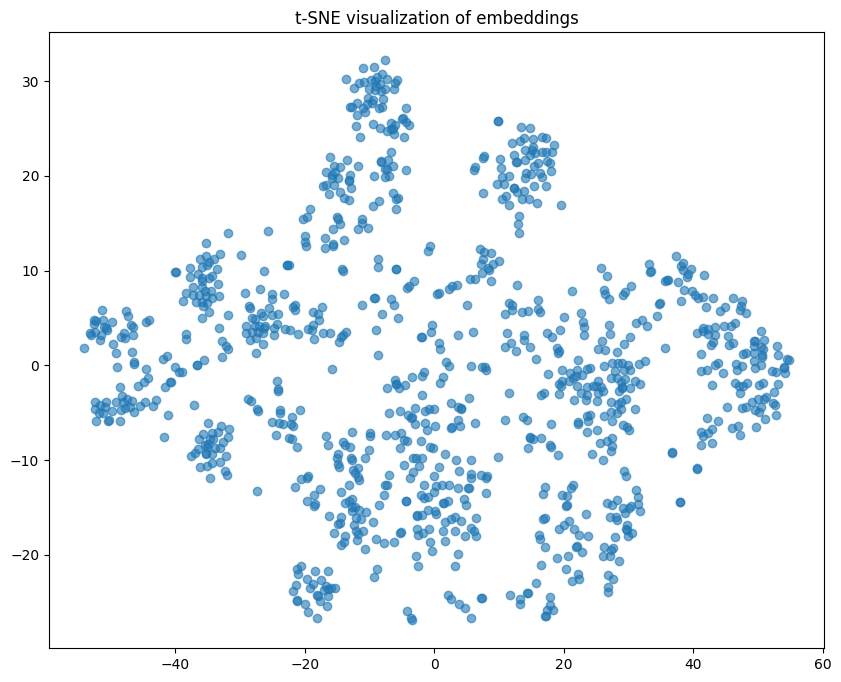

In [11]:
import h5py
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(file_path, num_samples=1000):
    with h5py.File(file_path, 'r') as f:
        # Randomly sample embeddings if there are too many
        keys = list(f.keys())
        if len(keys) > num_samples:
            keys = np.random.choice(keys, num_samples, replace=False)

        embeddings = np.array([f[key][()] for key in keys])

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
    plt.title('t-SNE visualization of embeddings')
    plt.show()

# Usage
visualize_embeddings('/content/drive/MyDrive/ERA v2/multimodal-system/image_embeddings.h5')